# InstantID: Zero-shot Identity-Preserving Generation using OpenVINO

Nowadays has been significant progress in personalized image synthesis with methods such as Textual Inversion, DreamBooth, and LoRA.
However, their real-world applicability is hindered by high storage demands, lengthy fine-tuning processes, and the need for multiple reference images. Conversely, existing ID embedding-based methods, while requiring only a single forward inference, face challenges: they either necessitate extensive fine-tuning across numerous model parameters, lack compatibility with community pre-trained models, or fail to maintain high face fidelity. 

[InstantID](https://instantid.github.io/) is a tuning-free method to achieve ID-Preserving generation with only single image, supporting various downstream tasks.
![applications.png](https://github.com/InstantID/InstantID/blob/main/assets/applications.png?raw=true)

Given only one reference ID image, InstantID aims to generate customized images with various poses or styles from a single reference ID image while ensuring high fidelity. Following figure provides an overview of the method. It incorporates three crucial components: 

1. An ID embedding that captures robust semantic face information; 
2. A lightweight adapted module with decoupled cross-attention, facilitating the use of an image as a visual prompt;
3. An IdentityNet that encodes the detailed features from the reference facial image with additional spatial control.

![instantid-components.png](https://instantid.github.io/static/documents/pipeline.png)

The difference InstantID from previous works in the following aspects: 
1. do not involve UNet training, so it can preserve the generation ability of the original text-to-image model and be compatible with existing pre-trained models and ControlNets in the community;
2. doesn't require test-time tuning, so for a specific character, there is no need to collect multiple images for fine-tuning, only a single image needs to be inferred once;
3. achieve better face fidelity, and retain the editability of text.

You can find more details about the approach with [project web page](https://instantid.github.io/), [paper](https://arxiv.org/abs/2401.07519) and [original repository](https://github.com/InstantID/InstantID)

In this tutorial, we consider how to use InstantID with OpenVINO.

## Prerequisites

In [1]:
from pathlib import Path
import sys

repo_dir = Path("InstantID")

if not repo_dir.exists():
    !git clone https://github.com/InstantID/InstantID.git

sys.path.append(str(repo_dir))

In [2]:
%pip install -q "openvino>=2023.3.0" opencv-python transformers diffusers accelerate gdown


[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


## Convert and prepare Face IdentityNet

For getting face embeddings and pose key points, InstantID uses [InsightFace](https://github.com/deepinsight/insightface) face analytic library. Its models are distributed in ONNX format and can be run with OpenVINO.
For preparing the face image, we need to detect the bounding boxes and keypoints for the face using the RetinaFace model, crop the detected face, align the face location using landmarks, and provide each face into the Arcface face embedding model for getting the person's identity embeddings.

The code below downloads the InsightFace Antelopev2 model kit and provides a simple interface compatible with InsightFace for getting face recognition results.

In [3]:
MODELS_DIR = Path("models")
face_detector_path = MODELS_DIR / "antelopev2" / "scrfd_10g_bnkps.onnx"
face_embeddings_path = MODELS_DIR / "antelopev2" / "glintr100.onnx"

In [4]:
from zipfile import ZipFile
import gdown

archive_file = Path("antelopev2.zip")

if not face_detector_path.exists() or face_embeddings_path.exists():
    if not archive_file.exists():
        gdown.download(
            "https://drive.google.com/uc?id=18wEUfMNohBJ4K3Ly5wpTejPfDzp-8fI8",
            str(archive_file),
        )
    with ZipFile(archive_file, "r") as zip_face_models:
        zip_face_models.extractall(MODELS_DIR)

In [5]:
import cv2
import math
import numpy as np
from skimage import transform as trans


def softmax(z):
    assert len(z.shape) == 2
    s = np.max(z, axis=1)
    s = s[:, np.newaxis]  # necessary step to do broadcasting
    e_x = np.exp(z - s)
    div = np.sum(e_x, axis=1)
    div = div[:, np.newaxis]  # dito
    return e_x / div


def distance2bbox(points, distance, max_shape=None):
    """Decode distance prediction to bounding box.

    Args:
        points (Tensor): Shape (n, 2), [x, y].
        distance (Tensor): Distance from the given point to 4
            boundaries (left, top, right, bottom).
        max_shape (tuple): Shape of the image.

    Returns:
        Tensor: Decoded bboxes.
    """
    x1 = points[:, 0] - distance[:, 0]
    y1 = points[:, 1] - distance[:, 1]
    x2 = points[:, 0] + distance[:, 2]
    y2 = points[:, 1] + distance[:, 3]
    if max_shape is not None:
        x1 = x1.clamp(min=0, max=max_shape[1])
        y1 = y1.clamp(min=0, max=max_shape[0])
        x2 = x2.clamp(min=0, max=max_shape[1])
        y2 = y2.clamp(min=0, max=max_shape[0])
    return np.stack([x1, y1, x2, y2], axis=-1)


def distance2kps(points, distance, max_shape=None):
    """Decode distance prediction to bounding box.

    Args:
        points (Tensor): Shape (n, 2), [x, y].
        distance (Tensor): Distance from the given point to 4
            boundaries (left, top, right, bottom).
        max_shape (tuple): Shape of the image.

    Returns:
        Tensor: Decoded bboxes.
    """
    preds = []
    for i in range(0, distance.shape[1], 2):
        px = points[:, i % 2] + distance[:, i]
        py = points[:, i % 2 + 1] + distance[:, i + 1]
        if max_shape is not None:
            px = px.clamp(min=0, max=max_shape[1])
            py = py.clamp(min=0, max=max_shape[0])
        preds.append(px)
        preds.append(py)
    return np.stack(preds, axis=-1)


def prepare_input(image, std, mean, reverse_channels=True):
    normalized_image = (image.astype(np.float32) - mean) / std
    if reverse_channels:
        normalized_image = normalized_image[:, :, ::-1]
    input_tensor = np.expand_dims(np.transpose(normalized_image, (2, 0, 1)), 0)
    return input_tensor


class RetinaFace:
    def __init__(self, ov_model):
        self.taskname = "detection"
        self.ov_model = ov_model
        self.center_cache = {}
        self.nms_thresh = 0.4
        self.det_thresh = 0.5
        self._init_vars()

    def _init_vars(self):
        self.input_size = (640, 640)
        outputs = self.ov_model.outputs
        self.input_mean = 127.5
        self.input_std = 128.0
        # print(self.output_names)
        # assert len(outputs)==10 or len(outputs)==15
        self.use_kps = False
        self._anchor_ratio = 1.0
        self._num_anchors = 1
        if len(outputs) == 6:
            self.fmc = 3
            self._feat_stride_fpn = [8, 16, 32]
            self._num_anchors = 2
        elif len(outputs) == 9:
            self.fmc = 3
            self._feat_stride_fpn = [8, 16, 32]
            self._num_anchors = 2
            self.use_kps = True
        elif len(outputs) == 10:
            self.fmc = 5
            self._feat_stride_fpn = [8, 16, 32, 64, 128]
            self._num_anchors = 1
        elif len(outputs) == 15:
            self.fmc = 5
            self._feat_stride_fpn = [8, 16, 32, 64, 128]
            self._num_anchors = 1
            self.use_kps = True

    def prepare(self, **kwargs):
        nms_thresh = kwargs.get("nms_thresh", None)
        if nms_thresh is not None:
            self.nms_thresh = nms_thresh
        det_thresh = kwargs.get("det_thresh", None)
        if det_thresh is not None:
            self.det_thresh = det_thresh
        input_size = kwargs.get("input_size", None)
        if input_size is not None:
            if self.input_size is not None:
                print("warning: det_size is already set in detection model, ignore")
            else:
                self.input_size = input_size

    def forward(self, img, threshold):
        scores_list = []
        bboxes_list = []
        kpss_list = []
        blob = prepare_input(img, self.input_mean, self.input_std, True)
        net_outs = self.ov_model(blob)

        input_height = blob.shape[2]
        input_width = blob.shape[3]
        fmc = self.fmc
        for idx, stride in enumerate(self._feat_stride_fpn):
            scores = net_outs[idx]
            bbox_preds = net_outs[idx + fmc]
            bbox_preds = bbox_preds * stride
            if self.use_kps:
                kps_preds = net_outs[idx + fmc * 2] * stride
            height = input_height // stride
            width = input_width // stride
            key = (height, width, stride)
            if key in self.center_cache:
                anchor_centers = self.center_cache[key]
            else:
                anchor_centers = np.stack(
                    np.mgrid[:height, :width][::-1], axis=-1
                ).astype(np.float32)
                anchor_centers = (anchor_centers * stride).reshape((-1, 2))
                if self._num_anchors > 1:
                    anchor_centers = np.stack(
                        [anchor_centers] * self._num_anchors, axis=1
                    ).reshape((-1, 2))
                if len(self.center_cache) < 100:
                    self.center_cache[key] = anchor_centers

            pos_inds = np.where(scores >= threshold)[0]
            bboxes = distance2bbox(anchor_centers, bbox_preds)
            pos_scores = scores[pos_inds]
            pos_bboxes = bboxes[pos_inds]
            scores_list.append(pos_scores)
            bboxes_list.append(pos_bboxes)
            if self.use_kps:
                kpss = distance2kps(anchor_centers, kps_preds)
                # kpss = kps_preds
                kpss = kpss.reshape((kpss.shape[0], -1, 2))
                pos_kpss = kpss[pos_inds]
                kpss_list.append(pos_kpss)
        return scores_list, bboxes_list, kpss_list

    def detect(self, img, input_size=None, max_num=0, metric="default"):
        assert input_size is not None or self.input_size is not None
        input_size = self.input_size if input_size is None else input_size

        im_ratio = float(img.shape[0]) / img.shape[1]
        model_ratio = float(input_size[1]) / input_size[0]
        if im_ratio > model_ratio:
            new_height = input_size[1]
            new_width = int(new_height / im_ratio)
        else:
            new_width = input_size[0]
            new_height = int(new_width * im_ratio)
        det_scale = float(new_height) / img.shape[0]
        resized_img = cv2.resize(img, (new_width, new_height))
        det_img = np.zeros((input_size[1], input_size[0], 3), dtype=np.uint8)
        det_img[:new_height, :new_width, :] = resized_img

        scores_list, bboxes_list, kpss_list = self.forward(det_img, self.det_thresh)

        scores = np.vstack(scores_list)
        scores_ravel = scores.ravel()
        order = scores_ravel.argsort()[::-1]
        bboxes = np.vstack(bboxes_list) / det_scale
        if self.use_kps:
            kpss = np.vstack(kpss_list) / det_scale
        pre_det = np.hstack((bboxes, scores)).astype(np.float32, copy=False)
        pre_det = pre_det[order, :]
        keep = self.nms(pre_det)
        det = pre_det[keep, :]
        if self.use_kps:
            kpss = kpss[order, :, :]
            kpss = kpss[keep, :, :]
        else:
            kpss = None
        if max_num > 0 and det.shape[0] > max_num:
            area = (det[:, 2] - det[:, 0]) * (det[:, 3] - det[:, 1])
            img_center = img.shape[0] // 2, img.shape[1] // 2
            offsets = np.vstack(
                [
                    (det[:, 0] + det[:, 2]) / 2 - img_center[1],
                    (det[:, 1] + det[:, 3]) / 2 - img_center[0],
                ]
            )
            offset_dist_squared = np.sum(np.power(offsets, 2.0), 0)
            if metric == "max":
                values = area
            else:
                values = (
                    area - offset_dist_squared * 2.0
                )  # some extra weight on the centering
            bindex = np.argsort(values)[::-1]  # some extra weight on the centering
            bindex = bindex[0:max_num]
            det = det[bindex, :]
            if kpss is not None:
                kpss = kpss[bindex, :]
        return det, kpss

    def nms(self, dets):
        thresh = self.nms_thresh
        x1 = dets[:, 0]
        y1 = dets[:, 1]
        x2 = dets[:, 2]
        y2 = dets[:, 3]
        scores = dets[:, 4]

        areas = (x2 - x1 + 1) * (y2 - y1 + 1)
        order = scores.argsort()[::-1]

        keep = []
        while order.size > 0:
            i = order[0]
            keep.append(i)
            xx1 = np.maximum(x1[i], x1[order[1:]])
            yy1 = np.maximum(y1[i], y1[order[1:]])
            xx2 = np.minimum(x2[i], x2[order[1:]])
            yy2 = np.minimum(y2[i], y2[order[1:]])

            w = np.maximum(0.0, xx2 - xx1 + 1)
            h = np.maximum(0.0, yy2 - yy1 + 1)
            inter = w * h
            ovr = inter / (areas[i] + areas[order[1:]] - inter)

            inds = np.where(ovr <= thresh)[0]
            order = order[inds + 1]

        return keep


arcface_dst = np.array(
    [
        [38.2946, 51.6963],
        [73.5318, 51.5014],
        [56.0252, 71.7366],
        [41.5493, 92.3655],
        [70.7299, 92.2041],
    ],
    dtype=np.float32,
)


def estimate_norm(lmk, image_size=112, mode="arcface"):
    assert lmk.shape == (5, 2)
    assert image_size % 112 == 0 or image_size % 128 == 0
    if image_size % 112 == 0:
        ratio = float(image_size) / 112.0
        diff_x = 0
    else:
        ratio = float(image_size) / 128.0
        diff_x = 8.0 * ratio
    dst = arcface_dst * ratio
    dst[:, 0] += diff_x
    tform = trans.SimilarityTransform()
    tform.estimate(lmk, dst)
    M = tform.params[0:2, :]
    return M


def norm_crop(img, landmark, image_size=112, mode="arcface"):
    M = estimate_norm(landmark, image_size, mode)
    warped = cv2.warpAffine(img, M, (image_size, image_size), borderValue=0.0)
    return warped


class FaceEmbeddings:
    def __init__(self, ov_model):
        self.ov_model = ov_model
        self.taskname = "recognition"
        input_mean = 127.5
        input_std = 127.5
        self.input_mean = input_mean
        self.input_std = input_std
        input_shape = self.ov_model.inputs[0].partial_shape
        self.input_size = (input_shape[3].get_length(), input_shape[2].get_length())
        self.input_shape = input_shape

    def get(self, img, kps):
        aimg = norm_crop(img, landmark=kps, image_size=self.input_size[0])
        embedding = self.get_feat(aimg).flatten()
        return embedding

    def get_feat(self, imgs):
        if not isinstance(imgs, list):
            imgs = [imgs]
        input_size = self.input_size
        blob = np.concatenate(
            [
                prepare_input(
                    cv2.resize(img, input_size), self.input_mean, self.input_std, True
                )
                for img in imgs
            ]
        )

        net_out = self.ov_model(blob)[0]
        return net_out

    def forward(self, batch_data):
        blob = (batch_data - self.input_mean) / self.input_std
        net_out = self.ov_model(blob)[0]
        return net_out


class OVFaceAnalysis:
    def __init__(self, detect_model, embedding_model):
        self.det_model = RetinaFace(detect_model)
        self.embed_model = FaceEmbeddings(embedding_model)

    def get(self, img, max_num=0):
        bboxes, kpss = self.det_model.detect(img, max_num=max_num, metric="default")
        if bboxes.shape[0] == 0:
            return []
        ret = []
        for i in range(bboxes.shape[0]):
            bbox = bboxes[i, 0:4]
            det_score = bboxes[i, 4]
            kps = None
            if kpss is not None:
                kps = kpss[i]
            embedding = self.embed_model.get(img, kps)
            ret.append(
                {"bbox": bbox, "score": det_score, "kps": kps, "embedding": embedding}
            )
        return ret

Now, let's see models inference result

### Select Inference Device for Face Recognition

In [6]:
import openvino as ov
import ipywidgets as widgets

core = ov.Core()

device = widgets.Dropdown(
    options=core.available_devices + ["AUTO"],
    value="AUTO",
    description="Device:",
    disabled=False,
)

device

Dropdown(description='Device:', index=3, options=('CPU', 'GPU.0', 'GPU.1', 'AUTO'), value='AUTO')

In [7]:
core = ov.Core()
face_detector = core.compile_model(face_detector_path, device.value)
face_embedding = core.compile_model(face_embeddings_path, device.value)

In [8]:
app = OVFaceAnalysis(face_detector, face_embedding)

### Perform Face Identity extraction

Now, we can apply our `OVFaceAnalysis` pipeline on an image for collection face embeddings and key points for reflection on the generated image

In [9]:
from pipeline_stable_diffusion_xl_instantid import draw_kps
from diffusers.utils import load_image

face_image = load_image(
    "https://huggingface.co/datasets/YiYiXu/testing-images/resolve/main/vermeer.jpg"
).resize((832, 800))
# prepare face emb
face_info = app.get(cv2.cvtColor(np.array(face_image), cv2.COLOR_RGB2BGR))
face_info = sorted(
    face_info, key=lambda x: (x["bbox"][2] - x["bbox"][0]) * x["bbox"][3] - x["bbox"][1]
)[
    -1
]  # only use the maximum face
face_emb = face_info["embedding"]
face_kps = draw_kps(face_image, face_info["kps"])

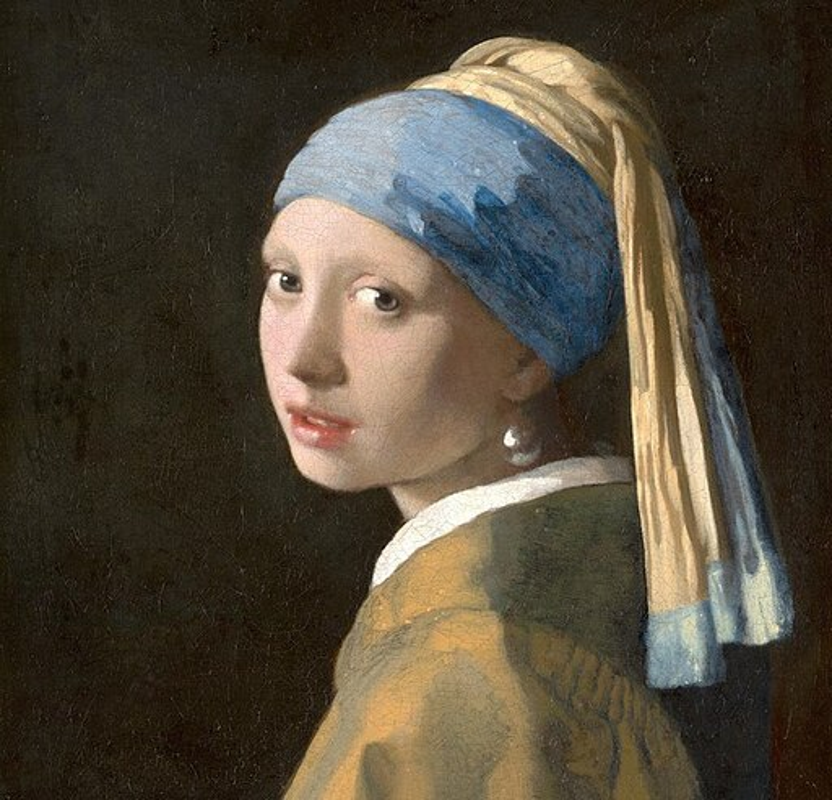

In [10]:
face_image

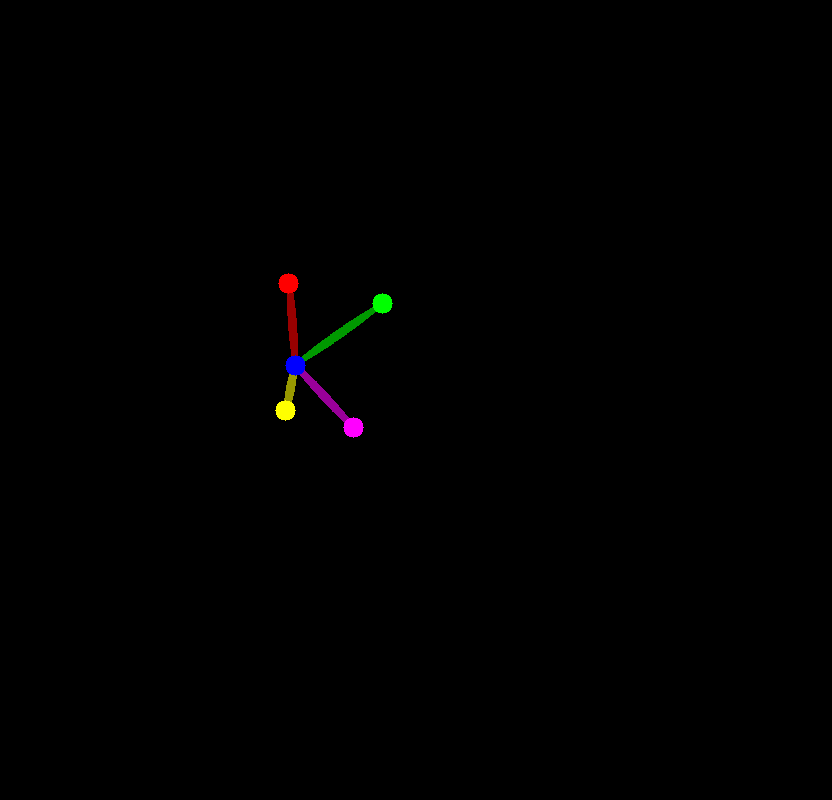

In [11]:
face_kps

## Prepare InstantID pipeline 

The code below downloads InstantID pipeline parts - ControlNet for face pose and IP-Adapter for adding face embeddings to prompt

In [12]:
from huggingface_hub import hf_hub_download

hf_hub_download(
    repo_id="InstantX/InstantID",
    filename="ControlNetModel/config.json",
    local_dir="./checkpoints",
)
hf_hub_download(
    repo_id="InstantX/InstantID",
    filename="ControlNetModel/diffusion_pytorch_model.safetensors",
    local_dir="./checkpoints",
)
hf_hub_download(
    repo_id="InstantX/InstantID", filename="ip-adapter.bin", local_dir="./checkpoints"
);

As it was discussed in model description, InstantID does not required diffusion model fine-tuning and can be applied on existing Stable Diffusion pipeline. We will use [`stable-diffusion-xl-bas-1-0`](https://huggingface.co/stabilityai/stable-diffusion-xl-base-1.0) as basic text-to-image diffusion pipeline. We also apply [LCM LoRA](https://huggingface.co/latent-consistency/lcm-lora-sdxl) to speedup the generation process. Previously, we already considered how to convert and run SDXL model for Text-to-Image and Image-to-Image generation using Optimum-Intel library (please check out this notebook for [details](../248-stable-diffusion-xl/248-stable-diffusion-xl.ipynb)), now we will use it in combination with ControlNet and convert it using OpenVINO Model Conversion API. 

In [13]:
from diffusers.models import ControlNetModel
from diffusers import LCMScheduler
from pipeline_stable_diffusion_xl_instantid import StableDiffusionXLInstantIDPipeline

import torch
from PIL import Image
import gc


ov_controlnet_path = MODELS_DIR / "controlnet.xml"
ov_unet_path = MODELS_DIR / "unet.xml"
ov_vae_decoder_path = MODELS_DIR / "vae_decoder.xml"
ov_text_encoder_path = MODELS_DIR / "text_encoder.xml"
ov_text_encoder_2_path = MODELS_DIR / "text_encoder_2.xml"
ov_image_proj_encoder_path = MODELS_DIR / "image_proj_model.xml"

required_pipeline_parts = [
    ov_controlnet_path,
    ov_unet_path,
    ov_vae_decoder_path,
    ov_text_encoder_path,
    ov_text_encoder_2_path,
    ov_image_proj_encoder_path,
]


def load_pytorch_pipeline(sdxl_id="stabilityai/stable-diffusion-xl-base-1.0"):
    # prepare models under ./checkpoints
    face_adapter = Path("checkpoints/ip-adapter.bin")
    controlnet_path = Path("checkpoints/ControlNetModel")

    # load IdentityNet
    controlnet = ControlNetModel.from_pretrained(controlnet_path)

    pipe = StableDiffusionXLInstantIDPipeline.from_pretrained(
        sdxl_id, controlnet=controlnet
    )

    # load adapter
    pipe.load_ip_adapter_instantid(face_adapter)
    # load lcm lora
    pipe.load_lora_weights("latent-consistency/lcm-lora-sdxl")
    pipe.fuse_lora()
    scheduler = LCMScheduler.from_config(pipe.scheduler.config)
    pipe.set_ip_adapter_scale(0.8)

    controlnet, unet, vae = pipe.controlnet, pipe.unet, pipe.vae
    text_encoder, text_encoder_2, tokenizer, tokenizer_2 = (
        pipe.text_encoder,
        pipe.text_encoder_2,
        pipe.tokenizer,
        pipe.tokenizer_2,
    )
    image_proj_model = pipe.image_proj_model
    return (
        controlnet,
        unet,
        vae,
        text_encoder,
        text_encoder_2,
        tokenizer,
        tokenizer_2,
        image_proj_model,
        scheduler,
    )


load_torch_models = any([not path.exists() for path in required_pipeline_parts])

if load_torch_models:
    (
        controlnet,
        unet,
        vae,
        text_encoder,
        text_encoder_2,
        tokenizer,
        tokenizer_2,
        image_proj_model,
        scheduler,
    ) = load_pytorch_pipeline()
    tokenizer.save_pretrained(MODELS_DIR / "tokenizer")
    tokenizer_2.save_pretrained(MODELS_DIR / "tokenizer_2")
    scheduler.save_pretrained(MODELS_DIR / "scheduler")
else:
    (
        controlnet,
        unet,
        vae,
        text_encoder,
        text_encoder_2,
        tokenizer,
        tokenizer_2,
        image_proj_model,
        scheduler,
    ) = (None, None, None, None, None, None, None, None, None)

gc.collect();

## Convert InstantID pipeline components to OpenVINO Intermediate Representation format

Starting from 2023.0 release, OpenVINO supports PyTorch models conversion directly. We need to provide a model object, input data for model tracing to `ov.convert_model` function to obtain OpenVINO `ov.Model` object instance. Model can be saved on disk for next deployment using `ov.save_model` function.

The pipeline consists of the following list of important parts:

* Image Projection model for getting image prompt embeddings. It is similar with IP-Adapter approach described in [this tutorial](../278-stable-diffusion-ip-adapter/278-stable-diffusion-ip-adapter.ipynb), but instead of image, it uses face embeddings as input for image prompt encoding.
* Text Encoders for creating text embeddings to generate an image from a text prompt.
* ControlNet for conditioning by face keypoints image for translation face pose on generated image.
* Unet for step-by-step denoising latent image representation.
* Autoencoder (VAE) for decoding latent space to image.


### ControlNet

ControlNet was introduced in [Adding Conditional Control to Text-to-Image Diffusion Models](https://arxiv.org/abs/2302.05543) paper. It provides a framework that enables support for various spatial contexts such as a depth map, a segmentation map, a scribble, and key points that can serve as additional conditionings to Diffusion models such as Stable Diffusion. In this [tutorial](../235-controlnet-stable-diffusion/235-controlnet-stable-diffusion.ipynb) we already considered how to convert and use ControlNet with Stable Diffusion pipeline. The process of usage ControlNet for Stable Diffusion XL remains without changes.

In [14]:
import openvino as ov
from functools import partial


def cleanup_torchscript_cache():
    """
    Helper for removing cached model representation
    """
    torch._C._jit_clear_class_registry()
    torch.jit._recursive.concrete_type_store = torch.jit._recursive.ConcreteTypeStore()
    torch.jit._state._clear_class_state()


controlnet_example_input = {
    "sample": torch.ones((2, 4, 100, 100)),
    "timestep": torch.tensor(1, dtype=torch.float32),
    "encoder_hidden_states": torch.randn((2, 77, 2048)),
    "controlnet_cond": torch.randn((2, 3, 800, 800)),
    "conditioning_scale": torch.tensor(0.8, dtype=torch.float32),
    "added_cond_kwargs": {
        "text_embeds": torch.zeros((2, 1280)),
        "time_ids": torch.ones((2, 6), dtype=torch.int32),
    },
}


if not ov_controlnet_path.exists():
    controlnet.forward = partial(controlnet.forward, return_dict=False)
    with torch.no_grad():
        ov_controlnet = ov.convert_model(
            controlnet, example_input=controlnet_example_input
        )
    ov_controlnet.inputs[-1].get_node().set_element_type(ov.Type.f32)
    ov_controlnet.inputs[-1].get_node().set_partial_shape(ov.PartialShape([-1, 6]))
    ov_controlnet.validate_nodes_and_infer_types()
    ov.save_model(ov_controlnet, ov_controlnet_path)
    cleanup_torchscript_cache()
    del ov_controlnet
    gc.collect()

if not ov_unet_path.exists():
    down_block_res_samples, mid_block_res_sample = controlnet(
        **controlnet_example_input
    )
else:
    down_block_res_samples, mid_block_res_sample = None, None

del controlnet
gc.collect();

### Unet

Compared with Stable Diffusion, Stable Diffusion XL Unet has an additional input for the `time_ids` condition. As we use ControlNet and Image Projection Model, these models' outputs also contribute to preparing model input for Unet.

In [15]:
from typing import Tuple


class UnetWrapper(torch.nn.Module):
    def __init__(
        self,
        unet,
        sample_dtype=torch.float32,
        timestep_dtype=torch.int64,
        encoder_hidden_states_dtype=torch.float32,
        down_block_additional_residuals_dtype=torch.float32,
        mid_block_additional_residual_dtype=torch.float32,
        text_embeds_dtype=torch.float32,
        time_ids_dtype=torch.int32,
    ):
        super().__init__()
        self.unet = unet
        self.sample_dtype = sample_dtype
        self.timestep_dtype = timestep_dtype
        self.encoder_hidden_states_dtype = encoder_hidden_states_dtype
        self.down_block_additional_residuals_dtype = (
            down_block_additional_residuals_dtype
        )
        self.mid_block_additional_residual_dtype = mid_block_additional_residual_dtype
        self.text_embeds_dtype = text_embeds_dtype
        self.time_ids_dtype = time_ids_dtype

    def forward(
        self,
        sample: torch.Tensor,
        timestep: torch.Tensor,
        encoder_hidden_states: torch.Tensor,
        down_block_additional_residuals: Tuple[torch.Tensor],
        mid_block_additional_residual: torch.Tensor,
        text_embeds: torch.Tensor,
        time_ids: torch.Tensor,
    ):
        sample.to(self.sample_dtype)
        timestep.to(self.timestep_dtype)
        encoder_hidden_states.to(self.encoder_hidden_states_dtype)
        down_block_additional_residuals = [
            res.to(self.down_block_additional_residuals_dtype)
            for res in down_block_additional_residuals
        ]
        mid_block_additional_residual.to(self.mid_block_additional_residual_dtype)
        added_cond_kwargs = {
            "text_embeds": text_embeds.to(self.text_embeds_dtype),
            "time_ids": time_ids.to(self.time_ids_dtype),
        }

        return self.unet(
            sample,
            timestep,
            encoder_hidden_states,
            down_block_additional_residuals=down_block_additional_residuals,
            mid_block_additional_residual=mid_block_additional_residual,
            added_cond_kwargs=added_cond_kwargs,
        )


if not ov_unet_path.exists():
    unet_example_input = {
        "sample": torch.ones((2, 4, 100, 100)),
        "timestep": torch.tensor(1, dtype=torch.float32),
        "encoder_hidden_states": torch.randn((2, 77, 2048)),
        "down_block_additional_residuals": down_block_res_samples,
        "mid_block_additional_residual": mid_block_res_sample,
        "text_embeds": torch.zeros((2, 1280)),
        "time_ids": torch.ones((2, 6), dtype=torch.int32),
    }
    unet = UnetWrapper(unet)
    with torch.no_grad():
        ov_unet = ov.convert_model(unet, example_input=unet_example_input)
    for i in range(3, len(ov_unet.inputs) - 2):
        ov_unet.inputs[i].get_node().set_element_type(ov.Type.f32)

    ov_unet.validate_nodes_and_infer_types()
    ov.save_model(ov_unet, ov_unet_path)
    del ov_unet
    cleanup_torchscript_cache()
    gc.collect()

del unet
gc.collect();

### VAE Decoder

The VAE model has two parts, an encoder and a decoder. The encoder is used to convert the image into a low dimensional latent representation, which will serve as the input to the U-Net model. The decoder, conversely, transforms the latent representation back into an image.
For InstantID pipeline we will use VAE only for decoding Unet generated image, it means that we can skip VAE encoder part conversion. 

In [16]:
class VAEDecoderWrapper(torch.nn.Module):
    def __init__(self, vae_decoder):
        super().__init__()
        self.vae = vae_decoder

    def forward(self, latents):
        return self.vae.decode(latents)


if not ov_vae_decoder_path.exists():
    vae_decoder = VAEDecoderWrapper(vae)

    with torch.no_grad():
        ov_vae_decoder = ov.convert_model(
            vae_decoder, example_input=torch.zeros((1, 4, 64, 64))
        )
    ov.save_model(ov_vae_decoder, ov_vae_decoder_path)
    del ov_vae_decoder
    cleanup_torchscript_cache()
    del vae_decoder
    gc.collect()

del vae
gc.collect();

### Text Encoders

The text-encoder is responsible for transforming the input prompt, for example, "a photo of an astronaut riding a horse" into an embedding space that can be understood by the U-Net. It is usually a simple transformer-based encoder that maps a sequence of input tokens to a sequence of latent text embeddings.

In [17]:
inputs = {"input_ids": torch.ones((1, 77), dtype=torch.long)}

if not ov_text_encoder_path.exists():
    text_encoder.eval()
    text_encoder.config.output_hidden_states = True
    text_encoder.config.return_dict = False
    with torch.no_grad():
        ov_text_encoder = ov.convert_model(text_encoder, example_input=inputs)
    ov.save_model(ov_text_encoder, ov_text_encoder_path)
    del ov_text_encoder
    cleanup_torchscript_cache()
    gc.collect()

del text_encoder
gc.collect()

if not ov_text_encoder_2_path.exists():
    text_encoder_2.eval()
    text_encoder_2.config.output_hidden_states = True
    text_encoder_2.config.return_dict = False
    with torch.no_grad():
        ov_text_encoder = ov.convert_model(text_encoder_2, example_input=inputs)
    ov.save_model(ov_text_encoder, ov_text_encoder_2_path)
    del ov_text_encoder
    cleanup_torchscript_cache()
del text_encoder_2
gc.collect();

### Image Projection Model

Image projection model is responsible to transforming face embeddings to image prompt embeddings

In [18]:
if not ov_image_proj_encoder_path.exists():
    with torch.no_grad():
        ov_image_encoder = ov.convert_model(
            image_proj_model, example_input=torch.zeros((2, 1, 512))
        )
    ov.save_model(ov_image_encoder, ov_image_proj_encoder_path)
    del ov_image_encoder
    cleanup_torchscript_cache()
del image_proj_model
gc.collect();

## Prepare OpenVINO InstantID Pipeline

In [19]:
import numpy as np
from diffusers import StableDiffusionXLControlNetPipeline
from diffusers.pipelines.stable_diffusion_xl import StableDiffusionXLPipelineOutput
from typing import Any, Callable, Dict, List, Optional, Tuple, Union

import cv2

import numpy as np
import PIL.Image
import torch

from diffusers.image_processor import PipelineImageInput, VaeImageProcessor


class OVStableDiffusionXLInstantIDPipeline(StableDiffusionXLControlNetPipeline):
    def __init__(
        self,
        text_encoder,
        text_encoder_2,
        image_proj_model,
        controlnet,
        unet,
        vae_decoder,
        tokenizer,
        tokenizer_2,
        scheduler,
    ):
        self.text_encoder = text_encoder
        self.text_encoder_2 = text_encoder_2
        self.tokenizer = tokenizer
        self.tokenizer_2 = tokenizer_2
        self.image_proj_model = image_proj_model
        self.controlnet = controlnet
        self.unet = unet
        self.vae_decoder = vae_decoder
        self.scheduler = scheduler
        self.image_proj_model_in_features = 512
        self.vae_scale_factor = 8
        self.vae_scaling_factor = 0.13025
        self.image_processor = VaeImageProcessor(
            vae_scale_factor=self.vae_scale_factor, do_convert_rgb=True
        )
        self.control_image_processor = VaeImageProcessor(
            vae_scale_factor=self.vae_scale_factor,
            do_convert_rgb=True,
            do_normalize=False,
        )
        self._internal_dict = {}
        self._progress_bar_config = {}
        

    def _encode_prompt_image_emb(
        self, prompt_image_emb, num_images_per_prompt, do_classifier_free_guidance
    ):
        if isinstance(prompt_image_emb, torch.Tensor):
            prompt_image_emb = prompt_image_emb.clone().detach()
        else:
            prompt_image_emb = torch.tensor(prompt_image_emb)

        prompt_image_emb = prompt_image_emb.reshape(
            [1, -1, self.image_proj_model_in_features]
        )

        if do_classifier_free_guidance:
            prompt_image_emb = torch.cat(
                [torch.zeros_like(prompt_image_emb), prompt_image_emb], dim=0
            )
        else:
            prompt_image_emb = torch.cat([prompt_image_emb], dim=0)
        prompt_image_emb = self.image_proj_model(prompt_image_emb)[0]

        bs_embed, seq_len, _ = prompt_image_emb.shape
        prompt_image_emb = np.tile(prompt_image_emb, (1, num_images_per_prompt, 1))
        prompt_image_emb = prompt_image_emb.reshape(
            bs_embed * num_images_per_prompt, seq_len, -1
        )

        return prompt_image_emb

    def __call__(
        self,
        prompt: Union[str, List[str]] = None,
        prompt_2: Optional[Union[str, List[str]]] = None,
        image: PipelineImageInput = None,
        height: Optional[int] = None,
        width: Optional[int] = None,
        num_inference_steps: int = 50,
        guidance_scale: float = 5.0,
        negative_prompt: Optional[Union[str, List[str]]] = None,
        negative_prompt_2: Optional[Union[str, List[str]]] = None,
        num_images_per_prompt: Optional[int] = 1,
        eta: float = 0.0,
        generator: Optional[Union[torch.Generator, List[torch.Generator]]] = None,
        latents: Optional[torch.FloatTensor] = None,
        prompt_embeds: Optional[torch.FloatTensor] = None,
        negative_prompt_embeds: Optional[torch.FloatTensor] = None,
        pooled_prompt_embeds: Optional[torch.FloatTensor] = None,
        negative_pooled_prompt_embeds: Optional[torch.FloatTensor] = None,
        image_embeds: Optional[torch.FloatTensor] = None,
        output_type: Optional[str] = "pil",
        return_dict: bool = True,
        cross_attention_kwargs: Optional[Dict[str, Any]] = None,
        controlnet_conditioning_scale: Union[float, List[float]] = 1.0,
        guess_mode: bool = False,
        control_guidance_start: Union[float, List[float]] = 0.0,
        control_guidance_end: Union[float, List[float]] = 1.0,
        original_size: Tuple[int, int] = None,
        crops_coords_top_left: Tuple[int, int] = (0, 0),
        target_size: Tuple[int, int] = None,
        negative_original_size: Optional[Tuple[int, int]] = None,
        negative_crops_coords_top_left: Tuple[int, int] = (0, 0),
        negative_target_size: Optional[Tuple[int, int]] = None,
        clip_skip: Optional[int] = None,
        callback_on_step_end: Optional[Callable[[int, int, Dict], None]] = None,
        callback_on_step_end_tensor_inputs: List[str] = ["latents"],
        # IP adapter
        ip_adapter_scale=None,
        **kwargs,
    ):
        r"""
        The call function to the pipeline for generation.

        Args:
            prompt (`str` or `List[str]`, *optional*):
                The prompt or prompts to guide image generation. If not defined, you need to pass `prompt_embeds`.
            prompt_2 (`str` or `List[str]`, *optional*):
                The prompt or prompts to be sent to `tokenizer_2` and `text_encoder_2`. If not defined, `prompt` is
                used in both text-encoders.
            image (`torch.FloatTensor`, `PIL.Image.Image`, `np.ndarray`, `List[torch.FloatTensor]`, `List[PIL.Image.Image]`, `List[np.ndarray]`,:
                    `List[List[torch.FloatTensor]]`, `List[List[np.ndarray]]` or `List[List[PIL.Image.Image]]`):
                The ControlNet input condition to provide guidance to the `unet` for generation. If the type is
                specified as `torch.FloatTensor`, it is passed to ControlNet as is. `PIL.Image.Image` can also be
                accepted as an image. The dimensions of the output image defaults to `image`'s dimensions. If height__module.unet.up_blocks.0.upsamplers.0.conv.base_layer/aten::_convolu
                and/or width are passed, `image` is resized accordingly. If multiple ControlNets are specified in
                `init`, images must be passed as a list such that each element of the list can be correctly batched for
                input to a single ControlNet.
            height (`int`, *optional*, defaults to `self.unet.config.sample_size * self.vae_scale_factor`):
                The height in pixels of the generated image. Anything below 512 pixels won't work well for
                [stabilityai/stable-diffusion-xl-base-1.0](https://huggingface.co/stabilityai/stable-diffusion-xl-base-1.0)
                and checkpoints that are not specifically fine-tuned on low resolutions.
            width (`int`, *optional*, defaults to `self.unet.config.sample_size * self.vae_scale_factor`):
                The width in pixels of the generated image. Anything below 512 pixels won't work well for
                [stabilityai/stable-diffusion-xl-base-1.0](https://huggingface.co/stabilityai/stable-diffusion-xl-base-1.0)
                and checkpoints that are not specifically fine-tuned on low resolutions.
            num_inference_steps (`int`, *optional*, defaults to 50):
                The number of denoising steps. More denoising steps usually lead to a higher quality image at the
                expense of slower inference.
            guidance_scale (`float`, *optional*, defaults to 5.0):
                A higher guidance scale value encourages the model to generate images closely linked to the text
                `prompt` at the expense of lower image quality. Guidance scale is enabled when `guidance_scale > 1`.
            negative_prompt (`str` or `List[str]`, *optional*):
                The prompt or prompts to guide what to not include in image generation. If not defined, you need to
                pass `negative_prompt_embeds` instead. Ignored when not using guidance (`guidance_scale < 1`).
            negative_prompt_2 (`str` or `List[str]`, *optional*):
                The prompt or prompts to guide what to not include in image generation. This is sent to `tokenizer_2`
                and `text_encoder_2`. If not defined, `negative_prompt` is used in both text-encoders.
            num_images_per_prompt (`int`, *optional*, defaults to 1):
                The number of images to generate per prompt.
            eta (`float`, *optional*, defaults to 0.0):
                Corresponds to parameter eta (η) from the [DDIM](https://arxiv.org/abs/2010.02502) paper. Only applies
                to the [`~schedulers.DDIMScheduler`], and is ignored in other schedulers.
            generator (`torch.Generator` or `List[torch.Generator]`, *optional*):
                A [`torch.Generator`](https://pytorch.org/docs/stable/generated/torch.Generator.html) to make
                generation deterministic.
            latents (`torch.FloatTensor`, *optional*):
                Pre-generated noisy latents sampled from a Gaussian distribution, to be used as inputs for image
                generation. Can be used to tweak the same generation with different prompts. If not provided, a latents
                tensor is generated by sampling using the supplied random `generator`.
            prompt_embeds (`torch.FloatTensor`, *optional*):
                Pre-generated text embeddings. Can be used to easily tweak text inputs (prompt weighting). If not
                provided, text embeddings are generated from the `prompt` input argument.
            negative_prompt_embeds (`torch.FloatTensor`, *optional*):
                Pre-generated negative text embeddings. Can be used to easily tweak text inputs (prompt weighting). If
                not provided, `negative_prompt_embeds` are generated from the `negative_prompt` input argument.
            pooled_prompt_embeds (`torch.FloatTensor`, *optional*):
                Pre-generated pooled text embeddings. Can be used to easily tweak text inputs (prompt weighting). If
                not provided, pooled text embeddings are generated from `prompt` input argument.
            negative_pooled_prompt_embeds (`torch.FloatTensor`, *optional*):
                Pre-generated negative pooled text embeddings. Can be used to easily tweak text inputs (prompt
                weighting). If not provided, pooled `negative_prompt_embeds` are generated from `negative_prompt` input
                argument.
            image_embeds (`torch.FloatTensor`, *optional*):
                Pre-generated image embeddings.
            output_type (`str`, *optional*, defaults to `"pil"`):
                The output format of the generated image. Choose between `PIL.Image` or `np.array`.
            return_dict (`bool`, *optional*, defaults to `True`):
                Whether or not to return a [`~pipelines.stable_diffusion.StableDiffusionPipelineOutput`] instead of a
                plain tuple.
            controlnet_conditioning_scale (`float` or `List[float]`, *optional*, defaults to 1.0):
                The outputs of the ControlNet are multiplied by `controlnet_conditioning_scale` before they are added
                to the residual in the original `unet`. If multiple ControlNets are specified in `init`, you can set
                the corresponding scale as a list.
            control_guidance_start (`float` or `List[float]`, *optional*, defaults to 0.0):
                The percentage of total steps at which the ControlNet starts applying.
            control_guidance_end (`float` or `List[float]`, *optional*, defaults to 1.0):
                The percentage of total steps at which the ControlNet stops applying.
            original_size (`Tuple[int]`, *optional*, defaults to (1024, 1024)):
                If `original_size` is not the same as `target_size` the image will appear to be down- or upsampled.
                `original_size` defaults to `(height, width)` if not specified. Part of SDXL's micro-conditioning as
                explained in section 2.2 of
                [https://huggingface.co/papers/2307.01952](https://huggingface.co/papers/2307.01952).
            crops_coords_top_left (`Tuple[int]`, *optional*, defaults to (0, 0)):
                `crops_coords_top_left` can be used to generate an image that appears to be "cropped" from the position
                `crops_coords_top_left` downwards. Favorable, well-centered images are usually achieved by setting
                `crops_coords_top_left` to (0, 0). Part of SDXL's micro-conditioning as explained in section 2.2 of
                [https://huggingface.co/papers/2307.01952](https://huggingface.co/papers/2307.01952).
            target_size (`Tuple[int]`, *optional*, defaults to (1024, 1024)):
                For most cases, `target_size` should be set to the desired height and width of the generated image. If
                not specified it will default to `(height, width)`. Part of SDXL's micro-conditioning as explained in
                section 2.2 of [https://huggingface.co/papers/2307.01952](https://huggingface.co/papers/2307.01952).
            negative_original_size (`Tuple[int]`, *optional*, defaults to (1024, 1024)):
                To negatively condition the generation process based on a specific image resolution. Part of SDXL's
                micro-conditioning as explained in section 2.2 of
                [https://huggingface.co/papers/2307.01952](https://huggingface.co/papers/2307.01952). For more
                information, refer toencode_pro this issue thread: https://github.com/huggingface/diffusers/issues/4208.
            negative_crops_coords_top_left (`Tuple[int]`, *optional*, defaults to (0, 0)):
                To negatively condition the generation process based on a specific crop coordinates. Part of SDXL's
                micro-conditioning as explained in section 2.2 of
                [https://huggingface.co/papers/2307.01952](https://huggingface.co/papers/2307.01952). For more
                information, refer to this issue thread: https://github.com/huggingface/diffusers/issues/4208.
            negative_target_size (`Tuple[int]`, *optional*, defaults to (1024, 1024)):
                To negatively condition the generation process based on a target image resolution. It should be as same
                as the `target_size` for most cases. Part of SDXL's micro-conditioning as explained in section 2.2 of
                [https://huggingface.co/papers/2307.01952](https://huggingface.co/papers/2307.01952). For more
                information, refer to this issue thread: https://github.com/huggingface/diffusers/issues/4208.
            clip_skip (`int`, *optional*):
                Number of layers to be skipped from CLIP while computing the prompt embeddings. A value of 1 means that
                the output of the pre-final layer will be used for computing the prompt embeddings.

        Examples:

        Returns:
            [`~pipelines.stable_diffusion.StableDiffusionPipelineOutput`] or `tuple`:
                If `return_dict` is `True`, [`~pipelines.stable_diffusion.StableDiffusionPipelineOutput`] is returned,
                otherwise a `tuple` is returned containing the output images.
        """

        do_classifier_free_guidance = guidance_scale >= 1.0
        # align format for control guidance
        if not isinstance(control_guidance_start, list) and isinstance(
            control_guidance_end, list
        ):
            control_guidance_start = len(control_guidance_end) * [
                control_guidance_start
            ]
        elif not isinstance(control_guidance_end, list) and isinstance(
            control_guidance_start, list
        ):
            control_guidance_end = len(control_guidance_start) * [control_guidance_end]
        elif not isinstance(control_guidance_start, list) and not isinstance(
            control_guidance_end, list
        ):
            control_guidance_start, control_guidance_end = (
                [control_guidance_start],
                [control_guidance_end],
            )

        # 2. Define call parameters
        if prompt is not None and isinstance(prompt, str):
            batch_size = 1
        elif prompt is not None and isinstance(prompt, list):
            batch_size = len(prompt)
        else:
            batch_size = prompt_embeds.shape[0]

        (
            prompt_embeds,
            negative_prompt_embeds,
            pooled_prompt_embeds,
            negative_pooled_prompt_embeds,
        ) = self.encode_prompt(
            prompt,
            prompt_2,
            num_images_per_prompt,
            do_classifier_free_guidance,
            negative_prompt,
            negative_prompt_2,
            prompt_embeds=prompt_embeds,
            negative_prompt_embeds=negative_prompt_embeds,
            pooled_prompt_embeds=pooled_prompt_embeds,
            negative_pooled_prompt_embeds=negative_pooled_prompt_embeds,
            lora_scale=None,
            clip_skip=clip_skip,
        )

        # 3.2 Encode image prompt
        prompt_image_emb = self._encode_prompt_image_emb(
            image_embeds, num_images_per_prompt, do_classifier_free_guidance
        )

        # 4. Prepare image
        image = self.prepare_image(
            image=image,
            width=width,
            height=height,
            batch_size=batch_size * num_images_per_prompt,
            num_images_per_prompt=num_images_per_prompt,
            do_classifier_free_guidance=do_classifier_free_guidance,
            guess_mode=guess_mode,
        )
        height, width = image.shape[-2:]

        # 5. Prepare timesteps
        self.scheduler.set_timesteps(num_inference_steps)
        timesteps = self.scheduler.timesteps

        # 6. Prepare latent variables
        num_channels_latents = 4
        latents = self.prepare_latents(
            int(batch_size) * int(num_images_per_prompt),
            int(num_channels_latents),
            int(height),
            int(width),
            dtype=torch.float32,
            device=torch.device("cpu"),
            generator=generator,
            latents=latents,
        )

        # 7. Prepare extra step kwargs.
        extra_step_kwargs = self.prepare_extra_step_kwargs(generator, eta)
        # 7.1 Create tensor stating which controlnets to keep
        controlnet_keep = []
        for i in range(len(timesteps)):
            keeps = [
                1.0 - float(i / len(timesteps) < s or (i + 1) / len(timesteps) > e)
                for s, e in zip(control_guidance_start, control_guidance_end)
            ]
            controlnet_keep.append(keeps)

        # 7.2 Prepare added time ids & embeddings
        if isinstance(image, list):
            original_size = original_size or image[0].shape[-2:]
        else:
            original_size = original_size or image.shape[-2:]
        target_size = target_size or (height, width)

        add_text_embeds = pooled_prompt_embeds
        if self.text_encoder_2 is None:
            text_encoder_projection_dim = pooled_prompt_embeds.shape[-1]
        else:
            text_encoder_projection_dim = 1280

        add_time_ids = self._get_add_time_ids(
            original_size,
            crops_coords_top_left,
            target_size,
            text_encoder_projection_dim=text_encoder_projection_dim,
        )

        if negative_original_size is not None and negative_target_size is not None:
            negative_add_time_ids = self._get_add_time_ids(
                negative_original_size,
                negative_crops_coords_top_left,
                negative_target_size,
                text_encoder_projection_dim=text_encoder_projection_dim,
            )
        else:
            negative_add_time_ids = add_time_ids

        if do_classifier_free_guidance:
            prompt_embeds = np.concatenate(
                [negative_prompt_embeds, prompt_embeds], axis=0
            )
            add_text_embeds = np.concatenate(
                [negative_pooled_prompt_embeds, add_text_embeds], axis=0
            )
            add_time_ids = np.concatenate([negative_add_time_ids, add_time_ids], axis=0)

        add_time_ids = np.tile(add_time_ids, (batch_size * num_images_per_prompt, 1))
        encoder_hidden_states = np.concatenate(
            [prompt_embeds, prompt_image_emb], axis=1
        )

        # 8. Denoising loop
        with self.progress_bar(total=num_inference_steps) as progress_bar:
            for i, t in enumerate(timesteps):
                # expand the latents if we are doing classifier free guidance
                latent_model_input = (
                    torch.cat([latents] * 2) if do_classifier_free_guidance else latents
                )
                latent_model_input = self.scheduler.scale_model_input(
                    latent_model_input, t
                )

                # controlnet(s) inference
                control_model_input = latent_model_input

                cond_scale = controlnet_conditioning_scale

                controlnet_outputs = self.controlnet(
                    [
                        control_model_input,
                        t,
                        prompt_image_emb,
                        image,
                        cond_scale,
                        add_text_embeds,
                        add_time_ids,
                    ]
                )

                controlnet_additional_blocks = list(controlnet_outputs.values())

                # predict the noise residual
                noise_pred = self.unet(
                    [
                        latent_model_input,
                        t,
                        encoder_hidden_states,
                        *controlnet_additional_blocks,
                        add_text_embeds,
                        add_time_ids,
                    ]
                )[0]

                # perform guidance
                if do_classifier_free_guidance:
                    noise_pred_uncond, noise_pred_text = noise_pred[0], noise_pred[1]
                    noise_pred = noise_pred_uncond + guidance_scale * (
                        noise_pred_text - noise_pred_uncond
                    )

                # compute the previous noisy sample x_t -> x_t-1
                latents = self.scheduler.step(
                    torch.from_numpy(noise_pred),
                    t,
                    latents,
                    **extra_step_kwargs,
                    return_dict=False,
                )[0]
                progress_bar.update()

        if not output_type == "latent":
            image = self.vae_decoder(latents / self.vae_scaling_factor)[0]
        else:
            image = latents

        if not output_type == "latent":
            image = self.image_processor.postprocess(
                torch.from_numpy(image), output_type=output_type
            )

        if not return_dict:
            return (image,)

        return StableDiffusionXLPipelineOutput(images=image)

    def encode_prompt(
        self,
        prompt: str,
        prompt_2: Optional[str] = None,
        num_images_per_prompt: int = 1,
        do_classifier_free_guidance: bool = True,
        negative_prompt: Optional[str] = None,
        negative_prompt_2: Optional[str] = None,
        prompt_embeds: Optional[torch.FloatTensor] = None,
        negative_prompt_embeds: Optional[torch.FloatTensor] = None,
        pooled_prompt_embeds: Optional[torch.FloatTensor] = None,
        negative_pooled_prompt_embeds: Optional[torch.FloatTensor] = None,
        lora_scale: Optional[float] = None,
        clip_skip: Optional[int] = None,
    ):
        r"""
        Encodes the prompt into text encoder hidden states.

        Args:
            prompt (`str` or `List[str]`, *optional*):
                prompt to be encoded
            prompt_2 (`str` or `List[str]`, *optional*):
                The prompt or prompts to be sent to the `tokenizer_2` and `text_encoder_2`. If not defined, `prompt` is
                used in both text-encoders
            num_images_per_prompt (`int`):
                number of images that should be generated per prompt
            do_classifier_free_guidance (`bool`):
                whether to use classifier free guidance or not
            negative_prompt (`str` or `List[str]`, *optional*):
                The prompt or prompts not to guide the image generation. If not defined, one has to pass
                `negative_prompt_embeds` instead. Ignored when not using guidance (i.e., ignored if `guidance_scale` is
                less than `1`).
            negative_prompt_2 (`str` or `List[str]`, *optional*):
                The prompt or prompts not to guide the image generation to be sent to `tokenizer_2` and
                `text_encoder_2`. If not defined, `negative_prompt` is used in both text-encoders
            prompt_embeds (`torch.FloatTensor`, *optional*):
                Pre-generated text embeddings. Can be used to easily tweak text inputs, *e.g.* prompt weighting. If not
                provided, text embeddings will be generated from `prompt` input argument.
            negative_prompt_embeds (`torch.FloatTensor`, *optional*):
                Pre-generated negative text embeddings. Can be used to easily tweak text inputs, *e.g.* prompt
                weighting. If not provided, negative_prompt_embeds will be generated from `negative_prompt` input
                argument.
            pooled_prompt_embeds (`torch.FloatTensor`, *optional*):
                Pre-generated pooled text embeddings. Can be used to easily tweak text inputs, *e.g.* prompt weighting.
                If not provided, pooled text embeddings will be generated from `prompt` input argument.
            negative_pooled_prompt_embeds (`torch.FloatTensor`, *optional*):
                Pre-generated negative pooled text embeddings. Can be used to easily tweak text inputs, *e.g.* prompt
                weighting. If not provided, pooled negative_prompt_embeds will be generated from `negative_prompt`
                input argument.
            lora_scale (`float`, *optional*):
                A lora scale that will be applied to all LoRA layers of the text encoder if LoRA layers are loaded.
            clip_skip (`int`, *optional*):
                Number of layers to be skipped from CLIP while computing the prompt embeddings. A value of 1 means that
                the output of the pre-final layer will be used for computing the prompt embeddings.
        """
        prompt = [prompt] if isinstance(prompt, str) else prompt

        if prompt is not None:
            batch_size = len(prompt)
        else:
            batch_size = prompt_embeds.shape[0]

        # Define tokenizers and text encoders
        tokenizers = (
            [self.tokenizer, self.tokenizer_2]
            if self.tokenizer is not None
            else [self.tokenizer_2]
        )
        text_encoders = (
            [self.text_encoder, self.text_encoder_2]
            if self.text_encoder is not None
            else [self.text_encoder_2]
        )

        if prompt_embeds is None:
            prompt_2 = prompt_2 or prompt
            prompt_2 = [prompt_2] if isinstance(prompt_2, str) else prompt_2

            # textual inversion: procecss multi-vector tokens if necessary
            prompt_embeds_list = []
            prompts = [prompt, prompt_2]
            for prompt, tokenizer, text_encoder in zip(
                prompts, tokenizers, text_encoders
            ):
                text_inputs = tokenizer(
                    prompt,
                    padding="max_length",
                    max_length=tokenizer.model_max_length,
                    truncation=True,
                    return_tensors="pt",
                )

                text_input_ids = text_inputs.input_ids

                prompt_embeds = text_encoder(text_input_ids)

                # We are only ALWAYS interested in the pooled output of the final text encoder
                pooled_prompt_embeds = prompt_embeds[0]
                hidden_states = list(prompt_embeds.values())[1:]
                if clip_skip is None:
                    prompt_embeds = hidden_states[-2]
                else:
                    # "2" because SDXL always indexes from the penultimate layer.
                    prompt_embeds = hidden_states[-(clip_skip + 2)]

                prompt_embeds_list.append(prompt_embeds)

            prompt_embeds = np.concatenate(prompt_embeds_list, axis=-1)

        # get unconditional embeddings for classifier free guidance
        zero_out_negative_prompt = negative_prompt is None
        if (
            do_classifier_free_guidance
            and negative_prompt_embeds is None
            and zero_out_negative_prompt
        ):
            negative_prompt_embeds = np.zeros_like(prompt_embeds)
            negative_pooled_prompt_embeds = np.zeros_like(pooled_prompt_embeds)
        elif do_classifier_free_guidance and negative_prompt_embeds is None:
            negative_prompt = negative_prompt or ""
            negative_prompt_2 = negative_prompt_2 or negative_prompt

            # normalize str to list
            negative_prompt = (
                batch_size * [negative_prompt]
                if isinstance(negative_prompt, str)
                else negative_prompt
            )
            negative_prompt_2 = (
                batch_size * [negative_prompt_2]
                if isinstance(negative_prompt_2, str)
                else negative_prompt_2
            )

            uncond_tokens: List[str]
            if prompt is not None and type(prompt) is not type(negative_prompt):
                raise TypeError(
                    f"`negative_prompt` should be the same type to `prompt`, but got {type(negative_prompt)} !="
                    f" {type(prompt)}."
                )
            elif batch_size != len(negative_prompt):
                raise ValueError(
                    f"`negative_prompt`: {negative_prompt} has batch size {len(negative_prompt)}, but `prompt`:"
                    f" {prompt} has batch size {batch_size}. Please make sure that passed `negative_prompt` matches"
                    " the batch size of `prompt`."
                )
            else:
                uncond_tokens = [negative_prompt, negative_prompt_2]

            negative_prompt_embeds_list = []
            for negative_prompt, tokenizer, text_encoder in zip(
                uncond_tokens, tokenizers, text_encoders
            ):
                max_length = prompt_embeds.shape[1]
                uncond_input = tokenizer(
                    negative_prompt,
                    padding="max_length",
                    max_length=max_length,
                    truncation=True,
                    return_tensors="pt",
                )

                negative_prompt_embeds = text_encoder(uncond_input.input_ids)
                # We are only ALWAYS interested in the pooled output of the final text encoder
                negative_pooled_prompt_embeds = negative_prompt_embeds[0]
                hidden_states = list(negative_prompt_embeds.values())[1:]
                negative_prompt_embeds = hidden_states[-2]

                negative_prompt_embeds_list.append(negative_prompt_embeds)

            negative_prompt_embeds = np.concatenate(
                negative_prompt_embeds_list, axis=-1
            )

        bs_embed, seq_len, _ = prompt_embeds.shape
        # duplicate text embeddings for each generation per prompt, using mps friendly method
        prompt_embeds = np.tile(prompt_embeds, (1, num_images_per_prompt, 1))
        prompt_embeds = prompt_embeds.reshape(
            bs_embed * num_images_per_prompt, seq_len, -1
        )

        if do_classifier_free_guidance:
            # duplicate unconditional embeddings for each generation per prompt, using mps friendly method
            seq_len = negative_prompt_embeds.shape[1]
            negative_prompt_embeds = np.tile(
                negative_prompt_embeds, (1, num_images_per_prompt, 1)
            )
            negative_prompt_embeds = negative_prompt_embeds.reshape(
                batch_size * num_images_per_prompt, seq_len, -1
            )

        pooled_prompt_embeds = np.tile(
            pooled_prompt_embeds, (1, num_images_per_prompt)
        ).reshape(bs_embed * num_images_per_prompt, -1)
        if do_classifier_free_guidance:
            negative_pooled_prompt_embeds = np.tile(
                negative_pooled_prompt_embeds, (1, num_images_per_prompt)
            ).reshape(bs_embed * num_images_per_prompt, -1)

        return (
            prompt_embeds,
            negative_prompt_embeds,
            pooled_prompt_embeds,
            negative_pooled_prompt_embeds,
        )

    def prepare_image(
        self,
        image,
        width,
        height,
        batch_size,
        num_images_per_prompt,
        do_classifier_free_guidance=False,
        guess_mode=False,
    ):
        image = self.control_image_processor.preprocess(
            image, height=height, width=width
        ).to(dtype=torch.float32)
        image_batch_size = image.shape[0]

        if image_batch_size == 1:
            repeat_by = batch_size
        else:
            # image batch size is the same as prompt batch size
            repeat_by = num_images_per_prompt

        image = image.repeat_interleave(repeat_by, dim=0)

        if do_classifier_free_guidance and not guess_mode:
            image = torch.cat([image] * 2)

        return image

    def _get_add_time_ids(
        self,
        original_size,
        crops_coords_top_left,
        target_size,
        text_encoder_projection_dim,
    ):
        add_time_ids = list(original_size + crops_coords_top_left + target_size)
        add_time_ids = torch.tensor([add_time_ids])
        return add_time_ids


## Run OpenVINO pipeline inference

### Select inference device for InstantID

In [20]:
device

Dropdown(description='Device:', index=3, options=('CPU', 'GPU.0', 'GPU.1', 'AUTO'), value='AUTO')

In [21]:
text_encoder = core.compile_model(ov_text_encoder_path, device.value)
text_encoder_2 = core.compile_model(ov_text_encoder_2_path, device.value)
vae_decoder = core.compile_model(ov_vae_decoder_path, device.value)
unet = core.compile_model(ov_unet_path, device.value)
controlnet = core.compile_model(ov_controlnet_path, device.value)
image_proj_model = core.compile_model(ov_image_proj_encoder_path, device.value)

In [22]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(MODELS_DIR / "tokenizer")
tokenizer_2 = AutoTokenizer.from_pretrained(MODELS_DIR / "tokenizer_2")
scheduler = LCMScheduler.from_pretrained(MODELS_DIR / "scheduler")

The config attributes {'interpolation_type': 'linear', 'skip_prk_steps': True, 'use_karras_sigmas': False} were passed to LCMScheduler, but are not expected and will be ignored. Please verify your scheduler_config.json configuration file.


### Create pipeline

In [23]:
ov_pipe = OVStableDiffusionXLInstantIDPipeline(
    text_encoder,
    text_encoder_2,
    image_proj_model,
    controlnet,
    unet,
    vae_decoder,
    tokenizer,
    tokenizer_2,
    scheduler,
)

### Run inference

In [24]:
prompt = "Anime girl"
negative_prompt = ""

image = ov_pipe(
    prompt,
    image_embeds=face_emb,
    image=face_kps,
    num_inference_steps=4,
    negative_prompt=negative_prompt,
    guidance_scale=0.5,
    generator=torch.Generator(device="cpu").manual_seed(1749781188)
).images[0]

  0%|          | 0/4 [00:00<?, ?it/s]

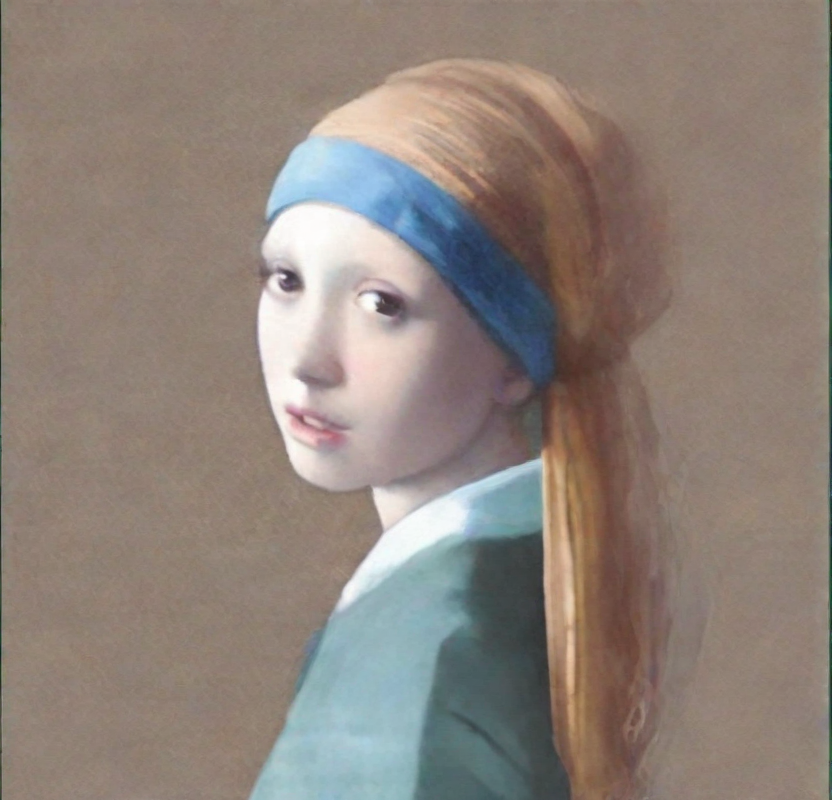

In [25]:
image

## Interactive demo

In [ ]:
import gradio as gr
from typing import Tuple
import random
import PIL

sys.path.append("./InstantID/gradio_demo")

from style_template import styles

# global variable
MAX_SEED = np.iinfo(np.int32).max
STYLE_NAMES = list(styles.keys())
DEFAULT_STYLE_NAME = "Watercolor"


def randomize_seed_fn(seed: int, randomize_seed: bool) -> int:
    if randomize_seed:
        seed = random.randint(0, MAX_SEED)
    return seed


def convert_from_cv2_to_image(img: np.ndarray) -> PIL.Image:
    return Image.fromarray(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))


def convert_from_image_to_cv2(img: PIL.Image) -> np.ndarray:
    return cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR)


def resize_img(
    input_image,
    max_side=1280,
    min_side=800,
    size=None,
    pad_to_max_side=False,
    mode=PIL.Image.BILINEAR,
    base_pixel_number=64,
):
    w, h = input_image.size
    if size is not None:
        w_resize_new, h_resize_new = size
    else:
        ratio = min_side / min(h, w)
        w, h = round(ratio * w), round(ratio * h)
        ratio = max_side / max(h, w)
        input_image = input_image.resize([round(ratio * w), round(ratio * h)], mode)
        w_resize_new = (round(ratio * w) // base_pixel_number) * base_pixel_number
        h_resize_new = (round(ratio * h) // base_pixel_number) * base_pixel_number
    input_image = input_image.resize([w_resize_new, h_resize_new], mode)

    if pad_to_max_side:
        res = np.ones([max_side, max_side, 3], dtype=np.uint8) * 255
        offset_x = (max_side - w_resize_new) // 2
        offset_y = (max_side - h_resize_new) // 2
        res[
            offset_y : offset_y + h_resize_new, offset_x : offset_x + w_resize_new
        ] = np.array(input_image)
        input_image = Image.fromarray(res)
    return input_image


def apply_style(style_name: str, positive: str, negative: str = "") -> Tuple[str, str]:
    p, n = styles.get(style_name, styles[DEFAULT_STYLE_NAME])
    return p.replace("{prompt}", positive), n + " " + negative


def generate_image(
    face_image,
    pose_image,
    prompt,
    negative_prompt,
    style_name,
    num_steps,
    identitynet_strength_ratio,
    guidance_scale,
    seed,
    progress=gr.Progress(track_tqdm=True),
):
    if prompt is None:
        prompt = "a person"

    # apply the style template
    prompt, negative_prompt = apply_style(style_name, prompt, negative_prompt)

    # face_image = load_image(face_image_path)
    face_image = resize_img(face_image)
    face_image_cv2 = convert_from_image_to_cv2(face_image)
    height, width, _ = face_image_cv2.shape

    # Extract face features
    face_info = app.get(face_image_cv2)

    if len(face_info) == 0:
        raise gr.Error(
            "Cannot find any face in the image! Please upload another person image"
        )

    face_info = sorted(
        face_info,
        key=lambda x: (x["bbox"][2] - x["bbox"][0]) * x["bbox"][3] - x["bbox"][1],
    )[
        -1
    ]  # only use the maximum face
    face_emb = face_info["embedding"]
    face_kps = draw_kps(convert_from_cv2_to_image(face_image_cv2), face_info["kps"])

    if pose_image is not None:
        # pose_image = load_image(pose_image_path)
        pose_image = resize_img(pose_image)
        pose_image_cv2 = convert_from_image_to_cv2(pose_image)

        face_info = app.get(pose_image_cv2)

        if len(face_info) == 0:
            raise gr.Error(
                "Cannot find any face in the reference image! Please upload another person image"
            )

        face_info = face_info[-1]
        face_kps = draw_kps(pose_image, face_info["kps"])

        width, height = face_kps.size

    generator = torch.Generator(device="cpu").manual_seed(seed)

    print("Start inference...")
    print(f"[Debug] Prompt: {prompt}, \n[Debug] Neg Prompt: {negative_prompt}")
    images = ov_pipe(
        prompt=prompt,
        negative_prompt=negative_prompt,
        image_embeds=face_emb,
        image=face_kps,
        controlnet_conditioning_scale=float(identitynet_strength_ratio),
        num_inference_steps=num_steps,
        guidance_scale=guidance_scale,
        height=height,
        width=width,
        generator=generator,
    ).images

    return images[0]


### Description
title = r"""
<h1 align="center">InstantID: Zero-shot Identity-Preserving Generation</h1>
"""

description = r"""

    How to use:<br>
    1. Upload an image with a face. For images with multiple faces, we will only detect the largest face. Ensure the face is not too small and is clearly visible without significant obstructions or blurring.
    2. (Optional) You can upload another image as a reference for the face pose. If you don't, we will use the first detected face image to extract facial landmarks. If you use a cropped face at step 1, it is recommended to upload it to define a new face pose.
    3. Enter a text prompt, as done in normal text-to-image models.
    4. Click the <b>Submit</b> button to begin customization.
    5. Share your customized photo with your friends and enjoy! 😊
    """


css = """
    .gradio-container {width: 85% !important}
    """
with gr.Blocks(css=css) as demo:
    # description
    gr.Markdown(title)
    gr.Markdown(description)

    with gr.Row():
        with gr.Column():
            # upload face image
            face_file = gr.Image(label="Upload a photo of your face", type="pil")

            # optional: upload a reference pose image
            pose_file = gr.Image(
                label="Upload a reference pose image (optional)", type="pil"
            )

            # prompt
            prompt = gr.Textbox(
                label="Prompt",
                info="Give simple prompt is enough to achieve good face fidelity",
                placeholder="A photo of a person",
                value="",
            )

            submit = gr.Button("Submit", variant="primary")
            style = gr.Dropdown(
                label="Style template", choices=STYLE_NAMES, value=DEFAULT_STYLE_NAME
            )

            # strength
            identitynet_strength_ratio = gr.Slider(
                label="IdentityNet strength (for fidelity)",
                minimum=0,
                maximum=1.5,
                step=0.05,
                value=0.80,
            )

            with gr.Accordion(open=False, label="Advanced Options"):
                negative_prompt = gr.Textbox(
                    label="Negative Prompt",
                    placeholder="low quality",
                    value="(lowres, low quality, worst quality:1.2), (text:1.2), watermark, (frame:1.2), deformed, ugly, deformed eyes, blur, out of focus, blurry, deformed cat, deformed, photo, anthropomorphic cat, monochrome, pet collar, gun, weapon, blue, 3d, drones, drone, buildings in background, green",
                )
                num_steps = gr.Slider(
                    label="Number of sample steps",
                    minimum=1,
                    maximum=10,
                    step=1,
                    value=4,
                )
                guidance_scale = gr.Slider(
                    label="Guidance scale", minimum=0.1, maximum=10.0, step=0.1, value=0
                )
                seed = gr.Slider(
                    label="Seed",
                    minimum=0,
                    maximum=MAX_SEED,
                    step=1,
                    value=42,
                )
                randomize_seed = gr.Checkbox(label="Randomize seed", value=True)

        with gr.Column():
            gallery = gr.Image(label="Generated Image")

    submit.click(
        fn=randomize_seed_fn,
        inputs=[seed, randomize_seed],
        outputs=seed,
        api_name=False,
    ).then(
        fn=generate_image,
        inputs=[
            face_file,
            pose_file,
            prompt,
            negative_prompt,
            style,
            num_steps,
            identitynet_strength_ratio,
            guidance_scale,
            seed,
        ],
        outputs=[gallery],
    )

demo.launch(share=True)